# Pros of adding details



## Description

author: laquitainesteeve@gmail.com

Execution time:

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz) with RTX 5090 GPU with 40GB VRAM (GPU not needed)

Prerequisites:
- storage: 13 GB for 1,500 templates
- RAM: 187 GB to simulate synthetic model with matched cell count & density to npx_spont.

RESULTS:

- **cell density**: 
    - The Buccino model places neurons sparsely in space, unrealistically so compared to real brain tissue. With fewer neurons, each spike is cleaner, and less overlapping occurs, thus spike sorting is easier. High-cell density should cell density should make spike sorting difficult since many similar waveforms will be picked up by each electrode, due to increased signal overlap, noise, and spike separability.
    - Consequence: With low-density cells and high yield, one can easily increase the yield by adding more electrodes, as each electrode would capture distinct spikes and more spatial sampling should increase the number of detected units. But if cell density is high and we only capture 10% of the neurons, adding more probes will not scale the yield linearly. You'll still get many overlapping spikes at each site. You'll hit the same separability limits. To improve yield in this case, you must increase electrode density (more sites per mm, closer spacing), which would produce better spatial resolution for disentangling overlapping spikes.
    - Reproducing experimentally-validated cell density and number of cells within 50 micron, allows us to make precise quantitative predictions about the single-unit and multi-unit yields that should be observed in vivo, which are experimentally testable.
    - **distribution of cell pairwise distances**: this parameter cannot be controlled to match experimentally validated locations, constrained by cell morphologies. Only the minimum distance can be controlled and the cells are randomly positioned. We position cells based identified in vivo constrains.
        - With the default overhang of 30 um, and 250 simulated cells, it is not possible to reproduce the average cell distances and density observed in vivo with mearec. Even a minimum distance of 0 um (min_dist paramer) produces an average cell distance of 29 um which is twice the in vivo distance of 14.8 um. The best match we can obtain is an average distance of 29 um, minimum of 4.8 um and max of 91 um against 15, 1.6 and 44 ums in the biophysical model. The original Buccino model display much larger values with 36, 25 and 66 ums.
        - One needs to increase the number of cells to match in vivo count within 50 um and to reduce the overhang to 20 um, in addition a minimum distance of 0 um.

`- **exc/inh ratio**: Buccino has twice more inhibitory relative to the inhibitory/excitatory ratio seen in vivo. Because the modeled inhibitory cells 
have higher firing rates than excitatory cells, this model will predict higher single-unit yield and sorting accuracy.


Methods:

- Buccino model: we assumed the model uses the default parameters, with each site model with a spatial extent of 10 contacts (ncontacts=10), with an x offset of 0, such that the MEA is not centered in the cell population.
    - 250 neurons: 
    - neuron locations cannot be closer than the min_dist parameter (default 25)
    - no cell metadata
    - channel location at x are all zero (default, inferred from doing running simulations) 

- We simulated one intermediate dataset with the same cell counts as npx_spont (100GB, 78 min). Because yield did not decrease to match npx_spont, but rather increased we simulated lower cell counts, we hereafter simulate a lower cell counts with the same exc/inh ratio (25GB, 23) for its efficiency. 10 simulations require take 1 TB storage! This setup is much faster to sort (10 min max)

- Buccino's model overhang: 30 (default) # extension in un beyond MEA boundaries for neuron locations (if lim is null)

- firing_range: no max_rate parameters so we matched min_rate, and firing exc and inh stds and check the resulting max_rate

DONE: 

- created 1,500 templates common to all simulations
- sort buccino rep
- sort synth2 - cell density|count 

DOING:

- simulate synth3 - firing rates (running) ...

TODO:

- sort synth3 - firing rates ...
- upload the recordings, ground truths & sorting extractors to dandi archive (if possible) [DOING]


## Setup 

Activate mearec virtual environment

In [226]:
%%time
%load_ext autoreload
%autoreload 2

# import packages
import os 
import MEArec as mr
import numpy as np
import spikeinterface.extractors as se 
import spikeinterface.sorters as sorters 
import spikeinterface.comparison as sc  
from matplotlib import pyplot as plt;
import spikeinterface as si
from spikeinterface.curation import remove_excess_spikes
from spikeinterface import extract_waveforms
import spikeinterface.qualitymetrics as sqm
import spikeinterface.core.template_tools as ttools
from numpy.linalg import norm as lalgnorm
import warnings
from scipy.spatial.distance import cdist
import json 

warnings.filterwarnings('ignore')

# SET PROJECT PATH

PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias/"
os.chdir(PROJ_PATH)

# import custom package
from src.nodes.validation import firing_rate as fr
from src.nodes.analysis.failures import isolation

# parameters
DURATION_S = 600 # duration of recording period considered in seconds

# SET DATA PATHS

# original buccino simulation
RECORDING_BUCCINO_PATH = 'dataset/01_intermediate/preprocessing/recording_buccino/'
GROUND_TRUTH_BUCCINO_PATH = 'dataset/00_raw/ground_truth_buccino/'
WAVEFORM_GT_BUCCINO_PATH =  './temp/pros_of_details/waveformextractor_buccino/'

# setup simulation common template parameters
DATA_PATH = './temp/pros_of_details/'
CELLS_PATH = mr.get_default_cell_models_folder()

# parameter Buccino replicate
TEMPLATE_PARAMS_PATH = './assets/mearec/global_templates.json' # templates used for all simulations
TEMPLATES_PATH = './temp/pros_of_details/templates.h5' # warning initially was not 1500 templates but much less 200 - check if that has an effect
INPUT_PARAMS_REP_PATH =  './assets/mearec/buccino_rep/input_params.json'
OUTPUT_PARAMS_REP_PATH = './assets/mearec/buccino_rep/output_params.json'
RECORDING_REP_H5_PATH = './temp/pros_of_details/recordings.h5'
RECORDING_REP_PATH = 'dataset/00_raw/recording_buccino_rep/'
GROUND_TRUTH_REP_PATH = 'dataset/00_raw/ground_truth_buccino_rep/'
WAVEFORM_GT_REP_PATH =  './temp/pros_of_details/waveformextractor_buccino_rep/'

# parameters synthetic 2 (cell density & count)
INPUT_PARAMS_S2_PATH =  './assets/mearec/synth2/input_params.json'
OUTPUT_PARAMS_S2_PATH = './assets/mearec/synth2/output_params.json'
RECORDING_S2_H5_PATH = './temp/pros_of_details/recording_synth2.h5'
RECORDING_S2_PATH = 'dataset/00_raw/recording_synth2/'
GROUND_TRUTH_S2_PATH = 'dataset/00_raw/ground_truth_synth2/'
WAVEFORM_GT_S2_PATH =  './temp/pros_of_details/waveformextractor_synth2/'

# parameters synthetic 3
INPUT_PARAMS_S3_PATH =  './assets/mearec/synth3/input_params.json'
OUTPUT_PARAMS_S3_PATH = './assets/mearec/synth3/output_params.json'
RECORDING_S3_H5_PATH = './temp/pros_of_details/recordings_s3.h5'
RECORDING_S3_PATH = 'dataset/00_raw/recording_synth3/'
GROUND_TRUTH_S3_PATH = 'dataset/00_raw/ground_truth_synth3/'
WAVEFORM_GT_S3_PATH =  './temp/pros_of_details/waveformextractor_synth3/'

# parameters synthetic 4
INPUT_PARAMS_S4_PATH =  './assets/mearec/buccino_s4/input_params.json'
OUTPUT_PARAMS_S4_PATH = './assets/mearec/buccino_s4/output_params.json'
RECORDING_S4_H5_PATH = './temp/pros_of_details/recordings_s4.h5'
RECORDING_S4_PATH = 'dataset/00_raw/recording_buccino_s4/'
GROUND_TRUTH_S4_PATH = 'dataset/00_raw/ground_truth_buccino_s4/'
WAVEFORM_GT_S4_PATH =  './temp/pros_of_details/waveformextractor_buccino_s4/'

# npx_spont
RECORDING_NS_PATH = 'dataset/01_intermediate/preprocessing/recording_npx_spont/'
GROUND_TRUTH_NS_PATH = 'dataset/00_raw/ground_truth_npx_spont/'
WAVEFORM_GT_NS_PATH = 'dataset/01_intermediate/waveforms/ground_truth_npx_spont/'
SORTING_KS4_NS_PATH = 'dataset/01_intermediate/sorting/npx_spont/SortingKS4_10m'

# parallel processing parameters
save_recording_params = {'n_jobs':20, 'verbose':True, 'progress_bar':True, 'overwrite':True, 'dtype':'float32', 'chunk_size': 50000}

# parallel processing parameters 
job_kwargs = dict(n_jobs=-1, chunk_duration="1s", progress_bar=True)
savefig_cfg = {"transparent":True, "dpi": 300}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 1.25 ms, sys: 0 ns, total: 1.25 ms
Wall time: 1.18 ms


## Custom functions

In [224]:
# UTILS 

def _euclidean_distance(coord_1, coord_2):
    return np.sqrt(np.sum((coord_1 - coord_2) ** 2))


def mad(data):
    mean_data = np.mean(data)
    return np.mean(np.absolute(data - mean_data))


def get_mad_ratio(spike_amp, noise_amp):
    """calculate an sd_ratio robust to outliers

    Args:
        spike_amp (_type_): _description_
        noise_amp (_type_): _description_

    Returns:
        _type_: _description_
    """
    mad_unit = mad(spike_amp)  # twice smaller than std
    mad_noise = mad(noise_amp)
    return mad_unit / mad_noise


def get_best_site_mad_noise(we, max_chids, unit):

    # get waveforms
    wv, _ = we.get_waveforms(unit_id=unit, with_index=True)

    # get channel ids (sparse)
    c_ids = we.sparsity.unit_id_to_channel_ids[unit]

    # get nearest channel
    max_chid = max_chids[unit]
    max_chid_ix = np.where(c_ids == max_chid)[0][0]
    return wv[:, :, max_chid_ix].flatten()


def get_waveform_amplitudes_per_unit(We):
    return si.postprocessing.compute_spike_amplitudes(We, peak_sign="neg", outputs="by_unit")[0]


def get_cell_locations(GroundTruth):

    x = GroundTruth.get_property('x')
    y = GroundTruth.get_property('y')
    z = GroundTruth.get_property('z')
    return np.array([x, y, z]).T


# SIMULATE SYNTHETIC RECORDING WITH MEAREC

def simulate_synthetic_recording_with_mearec(rec_prms: dict, layer:str, templates_path:str, recording_clone_h5_path:str):

    # generate simulated recording (takes 22 min)
    rec_gen = mr.gen_recordings(params=rec_prms, templates=templates_path)

    # save simulated recording
    mr.save_recording_generator(rec_gen, recording_clone_h5_path)

    # load recording h5 file
    RecordingClone = se.MEArecRecordingExtractor(recording_clone_h5_path) 
    RecordingClone.set_property("layers", np.array([layer]*384)) # add layer metadata

    # load ground truth
    SortingClone = se.MEArecSortingExtractor(recording_clone_h5_path)

    # delete intermediate h5 file
    os.remove(recording_clone_h5_path)
    return RecordingClone, SortingClone, rec_gen


def set_metadata_to_mearec_simulations(recording_generator, Recording, Sorting):
    
    # set cell features
    features = ['cell_type', 'snr', 'mtype', 'soma_position', 'bursting', 'exp_decay', 'max_spikes_per_burst', 'max_burst_duration']
    n_cells = len(recording_generator.spiketrains)

    # set cell properties in sorting extractor
    for feature in features:
        feature_data = []
        for cell_ix in range(n_cells):
            feature_data.append(recording_generator.spiketrains[cell_ix].annotations[feature])
        Sorting.set_property(feature, np.array(feature_data))

    # set electrode properties in recording extractor
    # by default, channel_locations are attached to Recording extractor
    Recording.set_property('layer', np.array(['L5']*384)) # layer
    return Recording, Sorting


def standardize_metadata(GroundTruth):
    """standardize ground truth extractor metadata
    from mearec simulatio

    Args:
        GroundTruth (_type_): _description_

    Returns:
        _type_: _description_
    """
    GroundTruth.set_property('x', GroundTruth.get_property('soma_position')[:,0])
    GroundTruth.set_property('y', GroundTruth.get_property('soma_position')[:,1])
    GroundTruth.set_property('z', GroundTruth.get_property('soma_position')[:,2])
    GroundTruth.delete_property('soma_position')

    GroundTruth.set_property('bursting', GroundTruth.get_property('bursting').astype(int))
    GroundTruth.set_property('exp_decay', GroundTruth.get_property('exp_decay').astype(str))
    GroundTruth.set_property('max_burst_duration', GroundTruth.get_property('max_burst_duration').astype(str))
    GroundTruth.set_property('max_spikes_per_burst', GroundTruth.get_property('max_spikes_per_burst').astype(str))
    return GroundTruth


def report_simulation_parameters(rec_gen):
    """
    Reports simulation parameters, checks for bursting, and displays example cell metadata.

    Args:
        rec_gen (RecordingGenerator): The recording generator object.
    """
    # report parameters
    display('Simulation parameters:', rec_gen.info)

    # check bursting
    bursting = []
    for ix in range(250):
        bursting.append(rec_gen.spiketrains[1].annotations['bursting'])
    print('Bursting:', any(bursting))

    # example of a cell metadata
    CELL_IDX = 0
    print('\nExample cell type:', rec_gen.template_celltypes[CELL_IDX])
    display('Its spiking metadata:', rec_gen.spiketrains[CELL_IDX].annotations)
    print('Its spike times:', rec_gen.spiketrains[CELL_IDX].times)


def save_simulation_parameters_to_assets(rec_prms:dict, rec_gen, input_params_path:str, output_params_path:str):
        
    folder_path = os.path.dirname(input_params_path)
    os.makedirs(folder_path, exist_ok=True)

    # save input simulation parameters to MEAREC
    with open(input_params_path, 'w') as f:
        json.dump(rec_prms, f, indent=4)

    folder_path = os.path.dirname(output_params_path)
    os.makedirs(folder_path, exist_ok=True)

    # save parameters recorded in recording generator
    with open(output_params_path, 'w') as f:
        json.dump(rec_gen.params, f, indent=4)

        
def get_cell_type_property_from_mearec(simulation):
    cell_types = []
    for ix in range(len(simulation.spiketrains)):
        cell_types.append(simulation.spiketrains[ix].annotations['cell_type'])
    return np.array(cell_types)


# DESCRIPTIVE FEATURES

def count_near_cells_within_radius(site_pos, cell_pos, unit_ids, radius=50):
    """
    Counts the number of unique cells within a specified radius from each site.

    Args:
        recording: SpikeInterface RecordingExtractor object.
        sorting: SpikeInterface SortingExtractor object.
        radius (int): Distance threshold in micrometers.

    Returns:
        int: Number of unique cells within the specified radius.
    """
    all_near_cells = []

    # for each site, find cells within the specified radius
    for pos in site_pos:
        tiled = np.tile(pos, (cell_pos.shape[0], 1))
        dist = np.linalg.norm(cell_pos - tiled, axis=1)
        near_cells = unit_ids[dist < radius]
        all_near_cells.extend(near_cells)
    all_near_cells = list(set(all_near_cells))
    return len(all_near_cells)


# QUALITY METRICS FOR A SINGLE UNIT

def get_spatial_spread(
    We, unit_id: int, max_chids: dict, channel_ids, channel_coord
):
    """measure unit's spatial spread

    Args:
        unit_id (int): _description_
        max_chids (dict): _description_
        Recording (_type_): _description_
        channel_ids (_type_): _description_
        channel_coord (_type_): _description_

    Returns:
        _type_: _description_
    """
    # get waveforms
    wv, _ = We.get_waveforms(unit_id=unit_id, with_index=True)    

    # get the site ids (sparse)
    c_ids = We.sparsity.unit_id_to_channel_ids[unit_id]

    # get the nearest site
    max_chid = max_chids[unit_id]
    max_chid_ix = np.where(c_ids == max_chid)[0][0]
    
    # get the average spike on each site
    mean_spikes = wv.mean(axis=0)
    max_spike = mean_spikes[:, max_chid_ix]
    
    # measure the average spike's similarity 
    # of each site to the average spike
    # of the nearest site to the unit
    # (ratio between 0 and 1)
    n_sites = mean_spikes.shape[1]
    cosim_weights = []
    for s_i in range(n_sites):
        cosim_weights.append(
            np.dot(max_spike, mean_spikes[:, s_i])
            / (lalgnorm(max_spike) * lalgnorm(mean_spikes[:, s_i]))
        )
    cosim_weights = np.array(cosim_weights)

    # threshold the similarity metric to be positive
    # we only look at similarity (not inverse similarity (<0))
    cosim_weights[cosim_weights < 0] = 0

    # measure the distance of the site to the nearest site
    # to the unit
    channel_coord = channel_coord[np.isin(channel_ids, c_ids), :]
    try:
        max_chids_coord = channel_coord[max_chid_ix, :]
    except:
        from ipdb import set_trace; set_trace()
        
    dist = []
    for ix, _ in enumerate(c_ids):
        dist.append(_euclidean_distance(max_chids_coord, channel_coord[ix]))
    dist = np.array(dist)

    # return spatial spread
    return {
        "spatial_spread": np.dot(cosim_weights, dist),
        "channel_distance": dist,
        "weights": cosim_weights,
    }


# QUALITY METRICS / SPIKE FEATURES FOR ALL UNITS

def get_cell_to_cell_distances(ground_truth):
    """Calculates the minimum cell-to-cell distances 
    based on soma location or x, y, z coordinates.

    Args:
        ground_truth: Ground truth extractor containing cell properties.

    Returns:
        numpy.ndarray: Minimum cell-to-cell distances or pairwise distances.
    """
    # if ground truth has a soma location property
    if 'soma_location' in ground_truth.get_property_keys():
        cell_loc = ground_truth.get_property('soma_location')
        cell_distance = cdist(cell_loc, cell_loc, metric='euclidean')
    elif 'x' in ground_truth.get_property_keys():
        # if ground truth has a x,y,z coordinates
        x = ground_truth.get_property('x')
        y = ground_truth.get_property('y')
        z = ground_truth.get_property('z')
        cell_pos = np.array([x, y, z]).T        
        cell_distance = cdist(cell_pos, cell_pos, metric='euclidean')
    else: 
        raise ValueError("""ground_truth should have a x, y, z coordinates or be in a 'soma_location' property""")
    
    # return distances
    np.fill_diagonal(cell_distance, np.nan)
    return np.nanmin(cell_distance, axis=0)    


def get_firing_rates(sorting, duration_s):
    """
    Plots the firing rate distribution of units in a sorting extractor.

    Parameters:
    - sorting: spikeinterface SortingExtractor
        The sorting extractor containing spike trains.
    - duration_s: the total duration
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    unit_ids = sorting.get_unit_ids()
    firing_rates = [
        len(sorting.get_unit_spike_train(unit_id)) / duration_s
        for unit_id in unit_ids
    ]
    return firing_rates


def get_firing_ranges(waveform_extractor):

    firing_range = sqm.compute_firing_ranges(waveform_extractor=waveform_extractor)
    return np.array(list(firing_range.values()))


def get_waveform_amplitude_medians(waveform_extractor):

    amplitude_medians = sqm.compute_amplitude_medians(waveform_extractor=waveform_extractor)
    return np.array(list(amplitude_medians.values()))


def get_waveform_snr(waveform_extractor):
    snrs = sqm.compute_snrs(waveform_extractor=waveform_extractor)
    return np.array(list(snrs.values()))


def get_spatial_spread_all_units(
    recording_path: str, study_path: str, ms_before=3, ms_after=3, peak_sign="neg"
):
    """get all units' spatial extent metrics

    Args:
        recording_path (str): Path of the Recording Extractor
        study_path (str): _description_
        ms_before (float): _description_
        ms_after (float): _description_

    Returns:
        (dict): spatial spread of each unit
        - key: true unit id
        - value: spatial spread
    
    Prerequisites:
        - have extracted ground truth waveforms
    """
    # takes 1:30 min
    We = si.WaveformExtractor.load_from_folder(study_path)
    
    # get sites' distance to the max site
    # get 3D coordinates
    Rec = si.load_extractor(recording_path)
    channel_coord = Rec.get_probe().contact_positions
    channel_ids = Rec.get_channel_ids()

    # get channels where spike amplitude is maximal
    max_chids = ttools.get_template_extremum_channel(
        We, peak_sign=peak_sign)

    # takes 1:30 min (1310 units)
    spatial_spread = dict()
    for _, unit in enumerate(We.unit_ids):
        spatial_spread[unit] = get_spatial_spread(
            We, unit, max_chids, channel_ids, channel_coord
        )["spatial_spread"]
    return np.array(list(spatial_spread.values()))


def get_mad_ratios(WeOriginal):
    """get mad ratio per unit. Values close to 1 indicate a good isolation of the unit.
    i.e., the mean absolute deviation of the spike amplitude is similar to the mean absolute deviation 
    of the noise amplitude.

    Args:
        WeOriginal (WaveformExtractor): _description_

    Returns:
        np.array: mad ratio per unit
    """
    # pre-compute negative spike amplitudes
    amplitudes_by_unit = get_waveform_amplitudes_per_unit(WeOriginal)

    # get nearest channels
    max_chids = ttools.get_template_extremum_channel(WeOriginal, peak_sign="both")

    # compute mad ratio per unit
    mad_ratio = []
    for unit in WeOriginal.unit_ids:
        noise_amp = get_best_site_mad_noise(WeOriginal, max_chids, unit)
        mad_ratio.append(get_mad_ratio(amplitudes_by_unit[unit], noise_amp))
    return np.array(mad_ratio)


# PLOTS 

def plot_firing_rate_distribution(ax, firing_rates, bins=20, title:str=None, ylim=(0,60), xlim=(0,25), edgecolor=(0.22, 0.5, 0.72), facecolor=(0.22, 0.5, 0.72), ylogscale=False, histtype='step'):
    """
    Plots the firing rate distribution of units in a sorting extractor.

    Parameters:
    - firing rates: firing rates
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(firing_rates, bins=bins, edgecolor=edgecolor, facecolor=facecolor, histtype=histtype)
    ax.set_xlabel("Firing rate (Hz)")
    ax.set_ylabel("Unit count")
    if title:
        ax.set_title(title)
    if ylogscale:
        ax.set_yscale('log')
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)    


def plot_firing_ranges_distribution(ax, firing_ranges, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800), edgecolor=(0.22, 0.5, 0.72), facecolor=(0.22, 0.5, 0.72), ylogscale=False, histtype='step'):
    """
    Parameters:
    - amplitudes: waveform amplitudes
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(firing_ranges, bins=bins, edgecolor=edgecolor, facecolor=facecolor, histtype=histtype)
    ax.set_xlabel("Firing range (Hz)")
    ax.set_ylabel("Unit count")
    if title:
        ax.set_title(title)
    if ylogscale:
        ax.set_yscale('log')
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)


def plot_waveform_amplitude_median_distribution(ax, amplitudes, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800), edgecolor=(0.22, 0.5, 0.72), facecolor=(0.22, 0.5, 0.72), ylogscale=False, histtype='step'):
    """
    Parameters:
    - amplitudes: waveform amplitudes
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(amplitudes, bins=bins, edgecolor=edgecolor, facecolor=facecolor, histtype=histtype)
    ax.set_xlabel("Amplitudes (uV)")
    ax.set_ylabel("Unit count")
    if title:
        ax.set_title(title)
    if ylogscale:
        ax.set_yscale('log')
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)


def plot_waveform_snr_distribution(ax, snrs, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800), edgecolor=(0.22, 0.5, 0.72), facecolor=(0.22, 0.5, 0.72), ylogscale=False, histtype='step'):
    """
    Parameters:
    - snrs: snrs
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(snrs, bins=bins, edgecolor=edgecolor, facecolor=facecolor, histtype=histtype)
    ax.set_xlabel("SNR")
    ax.set_ylabel("Unit count")
    if title:
        ax.set_title(title)
    if ylogscale:
        ax.set_yscale('log')
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)    


def plot_spatial_spread_distribution(ax, mad_ratio, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800), edgecolor=(0.22, 0.5, 0.72), facecolor=(0.22, 0.5, 0.72), ylogscale=False, histtype='step'):
    """
    Parameters:
    - mad_ratio: mad_ratio
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(mad_ratio, bins=bins, edgecolor=edgecolor, facecolor=facecolor, histtype=histtype)
    ax.set_xlabel("Spatial spread (a.u)")
    ax.set_ylabel("Unit count")
    if title:
        ax.set_title(title)
    if ylogscale:
        ax.set_yscale('log')
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)    


def plot_mad_ratio_distribution(ax, mad_ratios, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800), edgecolor=(0.22, 0.5, 0.72), facecolor=(0.22, 0.5, 0.72), ylogscale=False, histtype='step'):
    """
    Values close to 1 indicate a good isolation of the unit.
    i.e., the mean absolute deviation of the spike amplitude is similar to the mean absolute deviation 
    of the noise amplitude.
    
    Parameters:
    - mad_ratios: waveform mean-absolute deviation ratio between spike amplitude and background noise
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(mad_ratios, bins=bins, edgecolor=edgecolor, facecolor=facecolor, histtype=histtype)
    ax.set_xlabel("MAD ratios (a.u)")
    ax.set_ylabel("Unit count")
    if title:
        ax.set_title(title)
    if ylogscale:
        ax.set_yscale('log')
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)    


def plot_cell_to_cell_distances(ax, cell_distance, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800), edgecolor=(0.22, 0.5, 0.72), facecolor=(0.22, 0.5, 0.72), ylogscale=False, histtype='step'):
    """
    Parameters:
    - cell_distance: all cell-to-cell euclidean distances
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """    
    ax.hist(cell_distance, bins=bins, edgecolor=edgecolor, facecolor=facecolor, histtype=histtype)
    ax.set_xlabel("Cell distances (um)")
    ax.set_ylabel("Unit count")
    if title:
        ax.set_title(title)
    if ylogscale:
        ax.set_yscale('log')
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)    

# Quality of unit isolation (single-unit yield)

def process_each_experiment(sorted1, sorted2, sorted3, sorted4, sorted5, sorted6, exp_names):
    """
    Process sorting data by retrieving, filtering, and standardizing unit data.
    Keep units in L1 to L6 (in cortex)

    Returns:
        dict: A dictionary containing processed DataFrames for sorting data.
    """
    # get unit data
    sorting_data = {
        exp_names[0]: fr.get_sorted_unit_meta(sorted1),
        exp_names[1]: fr.get_sorted_unit_meta(sorted2),
        exp_names[2]: fr.get_sorted_unit_meta(sorted3),
        exp_names[3]: fr.get_sorted_unit_meta(sorted4),
        exp_names[4]: fr.get_sorted_unit_meta(sorted5),
        exp_names[5]: fr.get_sorted_unit_meta(sorted6)
    }

    # standardize layer 2/3
    for key in sorting_data:
        sorting_data[key]["layer"][
            (sorting_data[key]["layer"] == "L2") | (sorting_data[key]["layer"] == "L3") | (sorting_data[key]["layer"] == "L2_3")
        ] = "L2/3"

    # keep units in cortex
    for key in sorting_data:
        sorting_data[key] = sorting_data[key][
            np.isin(sorting_data[key]["layer"], ["L1", "L2", "L2/3", "L4", "L5", "L6"])
        ]
    return sorting_data

## Simulate synthetic datasets

- We simulate intermediate datasets with increasing levels of details and _in vivo_ accuracy to match the biophysical simulation (npx_spont) to assess the benefits of the added details.

In [215]:
# setup common cell templates, probe, and seed parameters (takes 4,531 secs)
tpl_prms = mr.get_default_templates_params()
tpl_prms['probe'] = 'Neuropixels-384'           # probe
tpl_prms['n'] = 1500                            # (default = 50) number of templates per cell model (minimum that worked to match npx_spont cell counts), I use 1500.
tpl_prms['seed'] = 0                            # setup reproducibility
tpl_prms['overhang'] = 50                       # (default = 30) extension in um beyond MEA boundaries for neuron locations
tpl_prms['ncontacts'] = 1                       # (default = 10) number of contacts per recording site, spatial extent of the electrode over which to average potential
tpl_prms['offset'] = 0                          # (default = 0) x offset; MEA is in the yz plane with x 0 by default. One can center the MEA in cell population by setting x offset.
tpl_prms['xlim'] = [-50, 50]                    # (default = [10,80]) limits ( low high ) for neuron locations in the x-axis (depth)
tpl_prms['ylim'] = None                         # (default = None) limits ( low high ) for neuron locations in the y-axis
tpl_prms['zlim'] = [-1001, 1001]                # (default = None) limits ( low high ) for neuron locations in the z-axis

# # create and save waveform templates (10 min for 200 templates per cell, 15 MB) - uncomment to run (1h20min)
# tpl_gen = mr.gen_templates(cell_models_folder = CELLS_PATH, params = tpl_prms)
# mr.save_template_generator(tpl_gen, TEMPLATES_PATH)

In [216]:
# setup common recording parameters
rec_prms = mr.get_default_recordings_params()
rec_prms['spiketrains']['duration'] = 600          # (default=600) recording duration
rec_prms['spiketrains']['min_rate'] = 0.5          # default value
rec_prms['seeds']['spiketrains'] = 0               # seeds for reproducibility 
rec_prms['seeds']['templates'] = 1
rec_prms['seeds']['noise'] = 2
rec_prms['seeds']['convolution'] = 3

# save common template parameters
with open(TEMPLATE_PARAMS_PATH, 'w') as f:
    json.dump(tpl_prms, f, indent=4)

### Buccino replicate

- This replicates Buccino et al., simulation with MEAREC as described in the Spikeinterface paper.
- Execution time: 23 min


In [11]:
%%time

# setup parameters
rec_prms['spiketrains']['n_exc'] = 200
rec_prms['spiketrains']['n_inh'] = 50

# simulate recording (23 min)
RecordingRep, SortingRep, RecGen = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_REP_H5_PATH)

# setup metadata
RecordingRep, SortingRep = set_metadata_to_mearec_simulations(RecGen, RecordingRep, SortingRep)
SortingRep = standardize_metadata(SortingRep)

# save extractors
RecordingRep.save(folder=RECORDING_REP_PATH, **save_recording_params)
SortingRep.save(folder=GROUND_TRUTH_REP_PATH, overwrite=True)

# save parameters
save_simulation_parameters_to_assets(rec_prms, RecGen, INPUT_PARAMS_REP_PATH, OUTPUT_PARAMS_REP_PATH)

# report parameters
# report_simulation_parameters(RecGen)
print('Sorting metadata:', si.load_extractor(GROUND_TRUTH_REP_PATH).get_property_keys())
print('Recording metadata:', si.load_extractor(RECORDING_REP_PATH).get_property_keys())

write_binary_recording with n_jobs = 20 and chunk_size = 50000


write_binary_recording:   0%|          | 0/384 [00:00<?, ?it/s]

Sorting metadata: ['z', 'y', 'bursting', 'mtype', 'exp_decay', 'x', 'max_burst_duration', 'max_spikes_per_burst', 'cell_type', 'snr']
Recording metadata: ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'layer', 'channel_name', 'layers']


### S2 - _in vivo_ cell density & count

- This matches cell count & density to the npx_spont model (validated against _in vivo_)
- Execution time: 1h10
- 5x more exc. cells
- 2x more inh.
- constrains: the large cell count requires more templates (at least 1,500) than Buccino's original else error: "Decrease number of spiketrains, decrease 'min_dist', or use more templates".


In [ ]:
# setup parameters
rec_prms['spiketrains']['n_exc'] = 1279       # (default = 200)
rec_prms['spiketrains']['n_inh'] = 109        # (default = 50)
rec_prms['templates']['min_dist'] = 0         # (default = 25), reduced to match mean cell-to-cell distance

# simulate recording (83 min)
RecordingS2, SortingS2, RecGenS2 = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_S2_H5_PATH)

# setup metadata
RecordingS2, SortingS2 = set_metadata_to_mearec_simulations(RecGenS2, RecordingS2, SortingS2)
SortingS2 = standardize_metadata(SortingS2)

# save extractors
RecordingS2.save(folder=RECORDING_S2_PATH, **save_recording_params)
SortingS2.save(folder=GROUND_TRUTH_S2_PATH, overwrite=True)

# save parameters
save_simulation_parameters_to_assets(rec_prms, RecGenS2, INPUT_PARAMS_S2_PATH, OUTPUT_PARAMS_S2_PATH)

# report parameters
# report_simulation_parameters(RecGen)
print(si.load_extractor(GROUND_TRUTH_S2_PATH).get_property_keys())
print(si.load_extractor(RECORDING_S2_PATH).get_property_keys())

Loading templates...
Done loading templates...
Spiketrains seed:  0
dtype float32
Noise Level  10
Templates selection seed:  1
Selecting cells
Padding template edges
Elapsed pad time: 8.170446634292603
Creating time jittering
Elapsed jitter time: 22.648691415786743
Smoothing templates
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  3
Electrode modulaton
Adding noise
Noise seed:  2
Filtering
Band-pass cutoff [ 300. 6000.] Hz
Elapsed time:  4480.859813356999
write_binary_recording with n_jobs = 20 and chunk_size = 50000


write_binary_recording:   0%|          | 0/384 [00:00<?, ?it/s]

['soma_position', 'bursting', 'mtype', 'exp_decay', 'max_burst_duration', 'max_spikes_per_burst', 'cell_type', 'snr']
['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'layer', 'channel_name', 'layers']


### S3 - _in vivo_ firing rate

In [ ]:
%%time

# change firing rates parameters, keep exc/inh ratio the same (sim too heavy to match the cells counts for all sims.)
rec_prms['spiketrains']['n_exc'] = 1279       # (default = 200)
rec_prms['spiketrains']['n_inh'] = 109        # (default = 50)
rec_prms['templates']['min_dist'] = 0         # (default = 25), reduced to match mean cell-to-cell distance

rec_prms['spiketrains']['f_exc'] = 0.3    # mean firing rate of excitatory cells in Hz (15 x lower)
rec_prms['spiketrains']['f_inh'] = 1      # mean firing rate of inhibitory cells in Hz (10 x lower)
rec_prms['spiketrains']['min_rate'] = 0   # same as npx_spont for 10 min recording (all cells fired for the entire recording)

# simulate recording with MEArec (23 min)
RecordingS3, SortingS3, RecGenS3 = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_S3_H5_PATH)

# set extractor properties (metadata)
RecordingS3, SortingS3 = set_metadata_to_mearec_simulations(RecGenS3, RecordingS3, SortingS3)
SortingS3 = standardize_metadata(SortingS3)

# save extractors
RecordingS3.save(folder=RECORDING_S3_PATH, **save_recording_params)
SortingS3.save(folder=GROUND_TRUTH_S3_PATH, overwrite=True)

# save simulation global parameters (reproducibility)
save_simulation_parameters_to_assets(rec_prms, RecGenS3, INPUT_PARAMS_S3_PATH, OUTPUT_PARAMS_S3_PATH)

# report parameters
# report_simulation_parameters(RecGen)
# report parameters
# report_simulation_parameters(RecGen)
print(si.load_extractor(GROUND_TRUTH_S3_PATH).get_property_keys())
print(si.load_extractor(RECORDING_S3_PATH).get_property_keys())

['z', 'y', 'bursting', 'mtype', 'exp_decay', 'x', 'max_burst_duration', 'max_spikes_per_burst', 'cell_type', 'snr']
['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'layer', 'channel_name', 'layers']


### S4 - FR range

In [ ]:
%%time

# change firing range (by adjusting st_exc and st_inh)
# check with:
#   firing_ranges = get_firing_ranges(WeGtNS)
#   display(firing_ranges.max())
#   display(firing_ranges[SortingGtNS.get_property('synapse_class')=='EXC'].std())
#   display(firing_ranges[SortingGtNS.get_property('synapse_class')=='INH'].std())
rec_prms['spiketrains']['n_exc'] = 200
rec_prms['spiketrains']['n_inh'] = 17
rec_prms['templates']['min_dist'] = 1.6
rec_prms['spiketrains']['f_exc'] = 0.3    # mean firing rate of exc cells in Hz (15 x lower)
rec_prms['spiketrains']['f_inh'] = 1      # mean firing rate of inh cells in Hz (10 x lower)
rec_prms['spiketrains']['min_rate'] = 0   # same as npx_spont for 10 min recording (all cells fired for the entire recording)

rec_prms['spiketrains']['st_exc'] = 0.20  # firing rate standard deviation of excitatory cells in Hz (produces empirically 0.34)
rec_prms['spiketrains']['st_inh'] = 0.45  # firing rate standard deviation of inhibitory cells in Hz (produces empirically 0.30)

# simulate recording with MEArec (23 min)
RecordingS4, SortingS4, RecGenS4 = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_S4_H5_PATH)

# set extractor properties (metadata)
RecordingS4, SortingS4 = set_metadata_to_mearec_simulations(RecGenS4, RecordingS4, SortingS4)

# save extractors
RecordingS4.save(folder=RECORDING_S4_PATH, **save_recording_params)
SortingS4.save(folder=GROUND_TRUTH_S4_PATH, overwrite=True)

# save simulation global parameters (reproducibility)
save_simulation_parameters_to_assets(rec_prms, RecGenS4, INPUT_PARAMS_S4_PATH, OUTPUT_PARAMS_S4_PATH)

# report parameters
# report_simulation_parameters(RecGen)

### S5 - SNR

In [ ]:
%%time

# change spike amplitudes
rec_prms['spiketrains']['n_exc'] = 200
rec_prms['spiketrains']['n_inh'] = 17
rec_prms['templates']['min_dist'] = 1.6
rec_prms['spiketrains']['f_exc'] = 0.3    # mean firing rate of exc cells in Hz (15 x lower)
rec_prms['spiketrains']['f_inh'] = 1      # mean firing rate of inh cells in Hz (10 x lower)
rec_prms['spiketrains']['min_rate'] = 0   # same as npx_spont for 10 min recording (all cells fired for the entire recording)
rec_prms['spiketrains']['st_exc'] = 0.30  # firing rate standard deviation of excitatory cells in Hz ()
rec_prms['spiketrains']['st_inh'] = 0.35  # firing rate standard deviation of inhibitory cells in Hz (produces empirically 0.26)

rec_prms['templates']['min_amp'] = 100    # minimum spike amplitude in uV
rec_prms['templates']['max_amp'] = 600    # maximum spike amplitude in uV

# simulate synthetic recording with MEArec (takes 78 min)
RecordingS4, SortingS4, RecGenS4 = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_S4_H5_PATH, RECORDING_S4_PATH, GROUND_TRUTH_S4_PATH, N_JOBS, CHUNKS)

# report parameters
report_simulation_parameters(RecGenS4)

## Load/compute data

- Execution time: 

In [229]:
%%time

# load orginal Buccino (already bandpass filtered 300 - 6000 Hz)
RecordingBucci = si.load_extractor(RECORDING_BUCCINO_PATH)
GtBucci = si.load_extractor(GROUND_TRUTH_BUCCINO_PATH)

# load Buccino clone (already bandpass filtered 300 - 6000 Hz)
RecordingRep = si.load_extractor(RECORDING_REP_PATH)
GtRep = si.load_extractor(GROUND_TRUTH_REP_PATH)

# load Buccino S2 (already bandpass filtered 300 - 6000 Hz)
RecordingS2 = si.load_extractor(RECORDING_S2_PATH)
GtS2 = si.load_extractor(GROUND_TRUTH_S2_PATH)

# load Buccino S3 (already bandpass filtered 300 - 6000 Hz)
RecordingS3 = si.load_extractor(RECORDING_S3_PATH)
GtS3 = si.load_extractor(GROUND_TRUTH_S3_PATH)

# # load Buccino S4 (already bandpass filtered 300 - 6000 Hz)
# RecordingS4 = si.load_extractor(RECORDING_S4_PATH)
# SortingGtS4 = si.load_extractor(GROUND_TRUTH_S4_PATH)

# load npx_spont (preprocessed high-pass filtered >300 Hz)
RecordingNS = si.load_extractor(RECORDING_NS_PATH)
GtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)
GtNS = remove_excess_spikes(GtNS, RecordingNS)
GtNS = GtNS.frame_slice(start_frame=0, end_frame=RecordingNS.get_sampling_frequency() * DURATION_S)

# extract waveforms (typically takes 20 secs)
WeGtBucci = extract_waveforms(RecordingBucci, GtBucci, WAVEFORM_GT_BUCCINO_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtRep = extract_waveforms(RecordingRep, GtRep, WAVEFORM_GT_REP_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtS2 = extract_waveforms(RecordingS2, GtS2, WAVEFORM_GT_S2_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtS3 = extract_waveforms(RecordingS3, GtS3, WAVEFORM_GT_S3_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

# WeGtS4 = extract_waveforms(RecordingS4, SortingGtS4, WAVEFORM_GT_S4_PATH,
#     sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
#     overwrite=True, seed=0, **job_kwargs)

WeGtNS = extract_waveforms(RecordingNS, GtNS, WAVEFORM_GT_NS_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

CPU times: user 1min 5s, sys: 3min 23s, total: 4min 29s
Wall time: 5min 46s


## Compute/plot spiking features

- Execution time: 3 min

- **MAD ratio**: Values close to 1 indicate a good isolation of the unit. i.e., the mean absolute deviation of the spike amplitude is similar to the mean absolute deviation of the noise amplitude.
    

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

CPU times: user 1min 18s, sys: 21.6 s, total: 1min 40s
Wall time: 2min 12s


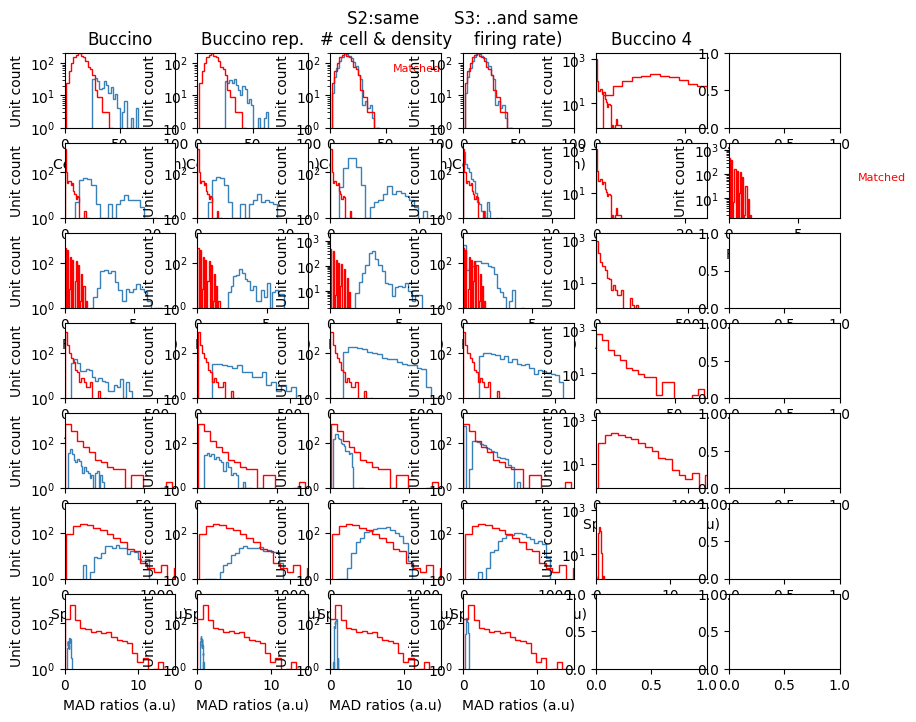

In [231]:
%%time

# setup  plot 
fig, axes = plt.subplots(7,6, figsize=(10,8))
YLIM = 2000 # works for log scale

# NS ---------------------

cell_distance_ns = get_cell_to_cell_distances(GtNS)
firing_rates_ns = get_firing_rates(GtNS, duration_s=600)
firing_ranges_ns = get_firing_ranges(WeGtNS)
amplitudes_ns = get_waveform_amplitude_medians(WeGtNS)
snrs_ns = get_waveform_snr(WeGtNS)
spreads_ns = get_spatial_spread_all_units(RECORDING_NS_PATH, WAVEFORM_GT_NS_PATH, ms_before=3, ms_after=3, peak_sign="neg")
mad_ratios_ns = get_mad_ratios(WeGtNS)

# BUCCINO  ----------------------

# cell-to-cell distances
cell_distance = get_cell_to_cell_distances(GtBucci)
plot_cell_to_cell_distances(axes[0,0], cell_distance, title='Buccino', ylim=(0,210), xlim=(0,100))
plot_cell_to_cell_distances(axes[0,0], cell_distance_ns, title='', ylim=(0,210), xlim=(0,100), edgecolor='r', facecolor='None', ylogscale=True)

# firing rates
firing_rates = get_firing_rates(GtBucci, duration_s=600) 
plot_firing_rate_distribution(axes[1,0], firing_rates, title='', ylim=(0,YLIM), xlim=(0,25))
plot_firing_rate_distribution(axes[1,0], firing_rates_ns, title='', ylim=(0,YLIM), xlim=(0,25), edgecolor='r', facecolor='None', ylogscale=True)

# firing range
firing_ranges = get_firing_ranges(WeGtBucci)
plot_firing_ranges_distribution(axes[2,0], firing_ranges, title='', ylim=(0,YLIM), xlim=(0,8))
plot_firing_ranges_distribution(axes[2,0], firing_ranges_ns, title='', ylim=(0,YLIM), xlim=(0,8), edgecolor='r', facecolor='None', ylogscale=True)

# waveform amplitudes
amplitudes_o = get_waveform_amplitude_medians(WeGtBucci)
plot_waveform_amplitude_median_distribution(axes[3,0], amplitudes_o, title='', ylim=(0,YLIM), xlim=(0,600))
plot_waveform_amplitude_median_distribution(axes[3,0], amplitudes_ns, title='', ylim=(0,YLIM), xlim=(0,600), edgecolor='r', facecolor='None', ylogscale=True)

# waveform signal-to-noise ratio (SNR)
snrs = get_waveform_snr(WeGtBucci)
plot_waveform_snr_distribution(axes[4,0], snrs, title='', ylim=(0,65), xlim=(0,YLIM))
plot_waveform_snr_distribution(axes[4,0], snrs_ns[np.isfinite(snrs_ns)], title='', ylim=(0,YLIM), xlim=(0,70), edgecolor='r', facecolor='None', ylogscale=True)

# waveform spatial spread
spreads = get_spatial_spread_all_units(RECORDING_BUCCINO_PATH, WAVEFORM_GT_BUCCINO_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[5,0], spreads, title='', ylim=(0,YLIM), xlim=(0,1200))
plot_spatial_spread_distribution(axes[5,0], spreads_ns, title='', ylim=(0,YLIM), xlim=(0,1200), edgecolor='r', facecolor='None', ylogscale=True)

# waveform mad ratio
mad_ratios = get_mad_ratios(WeGtBucci)
plot_mad_ratio_distribution(axes[6,0], mad_ratios, title='', ylim=(0,YLIM), xlim=(0,15))
plot_mad_ratio_distribution(axes[6,0], mad_ratios_ns, title='', ylim=(0,YLIM), xlim=(0,15), edgecolor='r', facecolor='None', ylogscale=True)

# BUCCINO REPLICATE ---------------------

cell_distance = get_cell_to_cell_distances(GtRep)
plot_cell_to_cell_distances(axes[0,1], cell_distance, title='Buccino rep.', ylim=(0,210), xlim=(0,100))
plot_cell_to_cell_distances(axes[0,1], cell_distance_ns, title='', ylim=(0,210), xlim=(0,100), edgecolor='r', facecolor='None', ylogscale=True)

firing_rates = get_firing_rates(GtRep, duration_s=600)
plot_firing_rate_distribution(axes[1,1], firing_rates, title='', ylim=(0,YLIM), xlim=(0,25))
plot_firing_rate_distribution(axes[1,1], firing_rates_ns, title='', ylim=(0,YLIM), xlim=(0,25), edgecolor='r', facecolor='None', ylogscale=True)

firing_ranges = get_firing_ranges(WeGtRep)
plot_firing_ranges_distribution(axes[2,1], firing_ranges, title='', ylim=(0,YLIM), xlim=(0,8))
plot_firing_ranges_distribution(axes[2,1], firing_ranges_ns, title='', ylim=(0,YLIM), xlim=(0,8), edgecolor='r', facecolor='None', ylogscale=True)

amplitudes_c = get_waveform_amplitude_medians(WeGtRep)
plot_waveform_amplitude_median_distribution(axes[3,1], amplitudes_c, title='', ylim=(0,YLIM), xlim=(0,600))
plot_waveform_amplitude_median_distribution(axes[3,1], amplitudes_ns, title='', ylim=(0,YLIM), xlim=(0,600), edgecolor='r', facecolor='None', ylogscale=True)

snrs = get_waveform_snr(WeGtRep)
plot_waveform_snr_distribution(axes[4,1], snrs, title='', ylim=(0,YLIM), xlim=(0,70))
plot_waveform_snr_distribution(axes[4,1], snrs_ns[np.isfinite(snrs_ns)], title='', ylim=(0,YLIM), xlim=(0,70), edgecolor='r', facecolor='None', ylogscale=True)

spreads = get_spatial_spread_all_units(RECORDING_REP_PATH, WAVEFORM_GT_REP_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[5,1], spreads, title='', ylim=(0,YLIM), xlim=(0,1200))
plot_spatial_spread_distribution(axes[5,1], spreads_ns, title='', ylim=(0,YLIM), xlim=(0,1200), edgecolor='r', facecolor='None', ylogscale=True)

mad_ratios = get_mad_ratios(WeGtRep)
plot_mad_ratio_distribution(axes[6,1], mad_ratios, title='', ylim=(0,YLIM), xlim=(0,15))
plot_mad_ratio_distribution(axes[6,1], mad_ratios_ns, title='', ylim=(0,YLIM), xlim=(0,15), edgecolor='r', facecolor='None', ylogscale=True)

# S2 ---------------------

cell_distance = get_cell_to_cell_distances(GtS2)
plot_cell_to_cell_distances(axes[0,2], cell_distance, title='S2:same \n# cell & density', ylim=(0,210), xlim=(0,100))
plot_cell_to_cell_distances(axes[0,2], cell_distance_ns, title='', ylim=(0,210), xlim=(0,100), edgecolor='r', facecolor='None', ylogscale=True)
axes[0,2].text(100,100, 'Matched', ha='right', va='top', fontsize=8, color='red')
    
firing_rates = get_firing_rates(GtS2, duration_s=600) # our S2
plot_firing_rate_distribution(axes[1,2], firing_rates, title='', ylim=(0,YLIM), xlim=(0,25))
plot_firing_rate_distribution(axes[1,2], firing_rates_ns, title='', ylim=(0,YLIM), xlim=(0,25), edgecolor='r', facecolor='None', ylogscale=True)

firing_ranges = get_firing_ranges(WeGtS2)
plot_firing_ranges_distribution(axes[2,2], firing_ranges, title='', ylim=(0,YLIM), xlim=(0,8))
plot_firing_ranges_distribution(axes[2,2], firing_ranges_ns, title='', ylim=(0,YLIM), xlim=(0,8), edgecolor='r', facecolor='None', ylogscale=True)

amplitudes_c = get_waveform_amplitude_medians(WeGtS2)
plot_waveform_amplitude_median_distribution(axes[3,2], amplitudes_c, title='', ylim=(0,YLIM), xlim=(0,600))
plot_waveform_amplitude_median_distribution(axes[3,2], amplitudes_ns, title='', ylim=(0,YLIM), xlim=(0,600), edgecolor='r', facecolor='None', ylogscale=True)

snrs = get_waveform_snr(WeGtS2)
plot_waveform_snr_distribution(axes[4,2], snrs, title='', ylim=(0,YLIM), xlim=(0,70))
plot_waveform_snr_distribution(axes[4,2], snrs_ns[np.isfinite(snrs_ns)], title='', ylim=(0,YLIM), xlim=(0,70), edgecolor='r', facecolor='None', ylogscale=True)

spreads = get_spatial_spread_all_units(RECORDING_S2_PATH, WAVEFORM_GT_S2_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[5,2], spreads, title='', ylim=(0,YLIM), xlim=(0,1200))
plot_spatial_spread_distribution(axes[5,2], spreads_ns, title='', ylim=(0,YLIM), xlim=(0,1200), edgecolor='r', facecolor='None', ylogscale=True)

mad_ratios = get_mad_ratios(WeGtS2)
plot_mad_ratio_distribution(axes[6,2], mad_ratios, title='', ylim=(0,YLIM), xlim=(0,15))
plot_mad_ratio_distribution(axes[6,2], mad_ratios_ns, title='', ylim=(0,YLIM), xlim=(0,15), edgecolor='r', facecolor='None', ylogscale=True)

# S3 ---------------------

cell_distance = get_cell_to_cell_distances(GtS3)
plot_cell_to_cell_distances(axes[0,3], cell_distance, title='S3: ..and same \nfiring rate)', ylim=(0,210), xlim=(0,100))
plot_cell_to_cell_distances(axes[0,3], cell_distance_ns, title='', ylim=(0,210), xlim=(0,100), edgecolor='r', facecolor='None', ylogscale=True)

firing_rates = get_firing_rates(GtS3, duration_s=600)
plot_firing_rate_distribution(axes[1,3], firing_rates, title='', ylim=(0,YLIM), xlim=(0,25))
plot_firing_rate_distribution(axes[1,3], firing_rates_ns, title='', ylim=(0,YLIM), xlim=(0,25), edgecolor='r', facecolor='None', ylogscale=True)
axes[1,3].text(100, 100, 'Matched', ha='right', va='top', fontsize=8, color='red')

firing_ranges = get_firing_ranges(WeGtS3)
plot_firing_ranges_distribution(axes[2,3], firing_ranges, title='', ylim=(0,YLIM), xlim=(0,8))
plot_firing_ranges_distribution(axes[2,3], firing_ranges_ns, title='', ylim=(0,YLIM), xlim=(0,8), edgecolor='r', facecolor='None', ylogscale=True)

amplitudes_c = get_waveform_amplitude_medians(WeGtS3)
plot_waveform_amplitude_median_distribution(axes[3,3], amplitudes_c, title='', ylim=(0,YLIM), xlim=(0,600))
plot_waveform_amplitude_median_distribution(axes[3,3], amplitudes_ns, title='', ylim=(0,YLIM), xlim=(0,600), edgecolor='r', facecolor='None', ylogscale=True)

snrs = get_waveform_snr(WeGtS3)
plot_waveform_snr_distribution(axes[4,3], snrs, title='', ylim=(0,65), xlim=(0,YLIM))
plot_waveform_snr_distribution(axes[4,3], snrs_ns[np.isfinite(snrs_ns)], title='', ylim=(0,YLIM), xlim=(0,70), edgecolor='r', facecolor='None', ylogscale=True)

spreads = get_spatial_spread_all_units(RECORDING_S3_PATH, WAVEFORM_GT_S3_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[5,3], spreads, title='', ylim=(0,YLIM), xlim=(0,1200))
plot_spatial_spread_distribution(axes[5,3], spreads_ns, title='', ylim=(0,YLIM), xlim=(0,1200), edgecolor='r', facecolor='None', ylogscale=True)

mad_ratios = get_mad_ratios(WeGtS3)
plot_mad_ratio_distribution(axes[6,3], mad_ratios, title='', ylim=(0,YLIM), xlim=(0,15))
plot_mad_ratio_distribution(axes[6,3], mad_ratios_ns, title='', ylim=(0,YLIM), xlim=(0,15), edgecolor='r', facecolor='None', ylogscale=True)

# S4 ---------------------

#cell_distance = get_cell_to_cell_distances(GtS4)
#plot_cell_to_cell_distances(axes[0,4], cell_distance, title='Synthetic 3', ylim=(0,210), xlim=(0,100))
plot_cell_to_cell_distances(axes[0,4], cell_distance_ns, title='', ylim=(0,210), xlim=(0,100), edgecolor='r', facecolor='None', ylogscale=True)

# firing_rates = get_firing_rates(GtS4, duration_s=600)
# plot_firing_rate_distribution(axes[1,4], firing_rates, title='', ylim=(0,YLIM), xlim=(0,8))
plot_firing_rate_distribution(axes[1,4], firing_rates_ns, title='', ylim=(0,YLIM), xlim=(0,25), edgecolor='r', facecolor='None', ylogscale=True)

# firing_ranges = get_firing_ranges(WeGtS4)
# plot_firing_ranges_distribution(axes[1,5], firing_ranges, title='', ylim=(0,YLIM), xlim=(0,8))
plot_firing_ranges_distribution(axes[1,5], firing_ranges_ns, title='', ylim=(0,YLIM), xlim=(0,8), edgecolor='r', facecolor='None', ylogscale=True)

# amplitudes_c = get_waveform_amplitude_medians(WeGtS4)
# plot_waveform_amplitude_median_distribution(axes[2,4], amplitudes_c, title='', ylim=(0,YLIM), xlim=(0,600))
plot_waveform_amplitude_median_distribution(axes[2,4], amplitudes_ns, title='', ylim=(0,YLIM), xlim=(0,600), edgecolor='r', facecolor='None', ylogscale=True)

# snrs = get_waveform_snr(WeGtS4)
# plot_waveform_snr_distribution(axes[3,4], snrs, title='', ylim=(0,YLIM), xlim=(0,2000))
plot_waveform_snr_distribution(axes[3,4], snrs_ns[np.isfinite(snrs_ns)], title='', ylim=(0,YLIM), xlim=(0,70), edgecolor='r', facecolor='None', ylogscale=True)

# firing_rates = get_firing_rates(GtS4, duration_s=600)
# plot_firing_rate_distribution(axes[0,4], firing_rates, title='Buccino 4', ylim=(0,YLIM), xlim=(0,25))
plot_firing_rate_distribution(axes[0,4], firing_rates_ns, title='Buccino 4', ylim=(0,YLIM), xlim=(0,25), edgecolor='r', facecolor='None', ylogscale=True)

# spreads = get_spatial_spread_all_units(RECORDING_S4_PATH, WAVEFORM_GT_S4_PATH, ms_before=3, ms_after=3, peak_sign="neg")
# plot_spatial_spread_distribution(axes[4,4], spreads, title='', ylim=(0,YLIM), xlim=(0,1200))
plot_spatial_spread_distribution(axes[4,4], spreads_ns, title='', ylim=(0,YLIM), xlim=(0,1200), edgecolor='r', facecolor='None', ylogscale=True)

# mad_ratios = get_mad_ratios(WeGtS4)
# plot_mad_ratio_distribution(axes[5,4], mad_ratios, title='', ylim=(0,YLIM), xlim=(0,15))
plot_mad_ratio_distribution(axes[5,4], mad_ratios, title='', ylim=(0,YLIM), xlim=(0,15), edgecolor='r', facecolor='None', ylogscale=True)


# CELL POSITIONS -----------------------

# distribution of distances to electrode [TODO]

fig.tight_layout(pad=0.1)

# save fig
plt.savefig("figures/7_reviews/figA_pros_of_details_matching_features.svg", **savefig_cfg)

## Yields

In [237]:
# SORTED_ks4_paths = {
#     "Buccino": 'dataset/01_intermediate/sorting/buccino/SortingKS4',
#     's_1\ncopy': './temp/npx_synth_clone/SortingKS4_10m_RTX5090',
#     's2\ncell count': './temp/npx_synth2/SortingKS4_10m_RTX5090',
#     's3\nrate': './temp/npx_synth3/SortingKS4_10m_RTX5090',
#     's4\nrange': './temp/npx_synth4/SortingKS4_10m_RTX5090',
#     "NS": SORTING_KS4_NS_PATH,
# }
SORTED_ks4_paths = {
    "Buccino": 'dataset/01_intermediate/sorting/buccino/SortingKS4',
    'Buccino\nrep': './temp/pros_of_details/npx_buccino_rep/SortingKS4_10m_RTX5090',
    's2\ncell count': './temp/pros_of_details/npx_synth2/SortingKS4_10m_RTX5090',
    's3\nf.rate': './temp/pros_of_details/npx_synth3/SortingKS4_10m_RTX5090',
    's4\nrange': './temp/pros_of_details/npx_synth3/SortingKS4_10m_RTX5090',
    "NS": SORTING_KS4_NS_PATH,
}

# plot parameters
FIGSIZE = (5.5, 2.2)
SHIFT = 0.3
exp_names = ('Buccino', 'Buccino\nrep', 's2\ncell count', 's3\nf.rate', 's4\nrange', 'NS')
number_pos = {'exp1_x':-0.3 + SHIFT, 'exp1_y_su': 0.2, 'exp1_y_mu': 0.8,
              'exp2_x': 0.7 + SHIFT, 'exp2_y_su': 0.2, 'exp2_y_mu': 0.8,
              'exp3_x': 1.7 + SHIFT, 'exp3_y_su': 0.2, 'exp3_y_mu': 0.87,
              'exp4_x': 2.7 + SHIFT, 'exp4_y_su': 0.2, 'exp4_y_mu': 0.87,
              'exp5_x': 3.7 + SHIFT, 'exp5_y_su': 0.2, 'exp5_y_mu': 0.87,
              'exp6_x': 4.7 + SHIFT, 'exp6_y_su': 0.2, 'exp6_y_mu': 0.87}
legend_cfg = {"frameon": False, "handletextpad": 0.1}

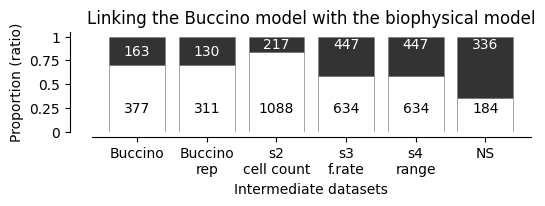

In [238]:
# compute data
plot_data = process_each_experiment(SORTED_ks4_paths['Buccino'], SORTED_ks4_paths['Buccino\nrep'], 
                                    SORTED_ks4_paths['s2\ncell count'], SORTED_ks4_paths['s3\nf.rate'], SORTED_ks4_paths['s4\nrange'], 
                                    SORTED_ks4_paths['NS'], exp_names)

# setup plot
_, ax = plt.subplots(1,1,figsize=FIGSIZE)

# plot (white: single-unit; black: multi-units)
isolation.plot_unit_isolation_pros_of_added_detailed(ax, plot_data['Buccino'], 
                                                     plot_data['Buccino\nrep'], plot_data['s2\ncell count'], plot_data['s3\nf.rate'], 
                                                     plot_data['s4\nrange'], plot_data['NS'], 
                                                     legend_cfg, number_pos, exp_names)

# legend
ax.set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
ax.set_title('Linking the Buccino model with the biophysical model')
plt.tight_layout()

# save figures
plt.savefig("figures/7_reviews/figB_pros_of_details_yield.svg", **savefig_cfg)

## Supplementary methods

TODO:
- store our cell positions and use them in buccino's simulation to get the exact same cell locations.
- number of single-units should increase by f^3 (upper bound)
- conclusion: it is important to use biological cell densities, which we use.

### Cell locations

- The MEA probes are located on the yz plane, with an adjustable x-offset (offset) set to 0  by default.

x (depth):
-min: -49.928803122976774
-max: 49.8361459345757

y:
-min: -73.96579222038521
-max: 73.79318388072528

z:
-min: -1000.5337516271763
-max: 1000.807144455734

x (depth):
-min: 3263.91095188888
-max: 4562.37147835935

y:
-min: -1485.1126678433502
-max: -987.4235813424148

z:
-min: -3233.206345506907
-max: -1723.7586189692386
S2 sites x-pitch:  40.0
S2 sites y-pitch:  25.612496949731394
S2 sites x-pitch: 39.99999999999982
S2 sites x-pitch: 25.612496949731355
max cell to cell distance: 2004.5641900203805
max cell to cell distance: 2002.312123185693


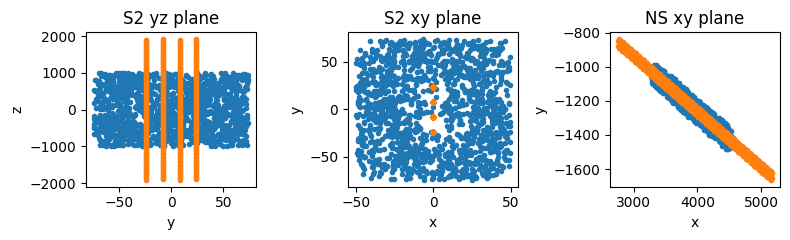

In [31]:
# get S2 cell locations
GtS2 = si.load_extractor(GROUND_TRUTH_S2_PATH)
locS2 = GtS2.get_property('soma_position')

print('x (depth):')
print('-min:', locS2[:,0].min())
print('-max:', locS2[:,0].max())
print('\ny:')
print('-min:', locS2[:,1].min())
print('-max:', locS2[:,1].max())
print('\nz:')
print('-min:', locS2[:,2].min())
print('-max:', locS2[:,2].max())

# get NS cell locations
GtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)
loc = get_cell_locations(GtNS)

print('\nx (depth):')
print('-min:', loc[:,0].min())
print('-max:', loc[:,0].max())
print('\ny:')
print('-min:', loc[:,1].min())
print('-max:', loc[:,1].max())
print('\nz:')
print('-min:', loc[:,2].min())
print('-max:', loc[:,2].max())

# setup plot
fig, ax = plt.subplots(1,3, figsize=(8,2.5))

# plot synthetic model with matched cell count, density and cell-to-cell distances, and electrodes
GtS2 = si.load_extractor(GROUND_TRUTH_S2_PATH)
locS2 = GtS2.get_property('soma_position')

recS2 = si.load_extractor(RECORDING_S2_PATH)
site_locS2 = recS2.get_property('location')
site_locS2 = np.insert(site_locS2, 0, 0, axis=1)
print('S2 sites x-pitch: ', _euclidean_distance(site_locS2[0,:], site_locS2[1,:]))
print('S2 sites y-pitch: ', _euclidean_distance(site_locS2[0,:], site_locS2[96,:]))

# yz plane
ax[0].plot(locS2[:,1], locS2[:,2],'.')
ax[0].plot(site_locS2[:,1], site_locS2[:,2],'.')
ax[0].set_xlabel('y')
ax[0].set_ylabel('z')
ax[0].set_title('S2 yz plane')

# xy plane
ax[1].plot(locS2[:,0], locS2[:,1],'.')
ax[1].plot(site_locS2[:,0], site_locS2[:,1],'.')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('S2 xy plane')

#plt.tight_layout()

# plot npx_spont cells and electrodes
GtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)
locNS = get_cell_locations(GtNS)

recNS = si.load_extractor(RECORDING_NS_PATH)
site_locNS = recNS.get_property('location')
print('S2 sites x-pitch:', _euclidean_distance(site_locNS[0,:], site_locNS[1,:]))
print('S2 sites x-pitch:', _euclidean_distance(site_locNS[0,:], site_locNS[96,:]))

ax[2].plot(locNS[:,0], locNS[:,1],'.')
ax[2].plot(site_locNS[:,0], site_locNS[:,1],'.')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[2].set_title('NS xy plane')

# print max cell distance
d = cdist(locNS, locNS)
np.fill_diagonal(d, np.nan)
print('max cell to cell distance:', np.nanmax(d))

# print max cell distance
d = cdist(locS2, locS2)
np.fill_diagonal(d, np.nan)
print('max cell to cell distance:', np.nanmax(d))

plt.tight_layout()


### Cell pairwise distances

Mean cell distance:
Buccino: 36.16760719122846 um
S1: 29.431237656752366 um
S2: 15.64415297126333 um
NS: 14.802049129567246 um

Minimum cell distance:
Buccino: 25.13684631204283 um
S1: 4.805265972690439 um
S2: 1.2471938050173546 um
NS: 1.648893994466453 um

Maximum cell distance:
Buccino: 66.31955554043584 um
S1: 91.31513646014825 um
S2: 44.079076800718525 um
NS: 44.11195332754986 um


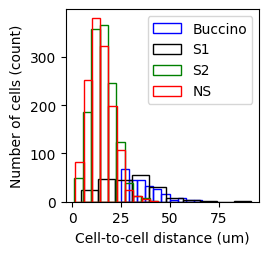

In [38]:
# plot
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))

# cell pairwise distances Buccino
GtBuccino = si.load_extractor(GROUND_TRUTH_BUCCINO_PATH)
loc = GtBuccino.get_property('soma_location')
d_buccino = cdist(loc, loc, metric='euclidean')
np.fill_diagonal(d_buccino, np.nan)
d_buccino = np.nanmin(d_buccino, axis=0)
ax.hist(d_buccino, facecolor='None', edgecolor='b')

# cell pairwise distances S1
GtS1 = si.load_extractor(GROUND_TRUTH_S1_PATH)
loc = GtS1.get_property('soma_position')
d_s1 = cdist(loc, loc, metric='euclidean')
np.fill_diagonal(d_s1, np.nan)
d_s1 = np.nanmin(d_s1, axis=0)
ax.hist(d_s1, facecolor='None', edgecolor='k')

# cell pairwise distances S2
GtS2 = si.load_extractor(GROUND_TRUTH_S2_PATH)
loc = GtS2.get_property('soma_position')
d_s2 = cdist(loc, loc, metric='euclidean')
np.fill_diagonal(d_s2, np.nan)
d_s2 = np.nanmin(d_s2, axis=0)
ax.hist(d_s2, facecolor='None', edgecolor='g')

# cell pairwise distances NS
GtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)
d_ns = get_cell_to_cell_distances(GtNS)
np.fill_diagonal(d_ns, np.nan)
d_ns = np.nanmin(d_ns, axis=0)

ax.hist(d_ns, facecolor='None', edgecolor='r');
ax.set_xlabel('Cell-to-cell distance (um)');
ax.set_ylabel('Number of cells (count)');
ax.legend(['Buccino', 'S1','S2', 'NS'])

print('Mean cell distance:')
print('Buccino:', d_buccino.mean(), 'um')
print('S1:', d_s1.mean(), 'um')
print('S2:', d_s2.mean(), 'um')
print('NS:', d_ns.mean(), 'um')

print('\nMinimum cell distance:')
print('Buccino:', d_buccino.min(), 'um')
print('S1:', d_s1.min(), 'um')
print('S2:', d_s2.min(), 'um')
print('NS:', d_ns.min(), 'um')

print('\nMaximum cell distance:')
print('Buccino:', d_buccino.max(), 'um')
print('S1:', d_s1.max(), 'um')
print('S2:', d_s2.max(), 'um')
print('NS:', d_ns.max(), 'um')

### Nb of cells w/n 50 um

In [34]:
# load dataset
RecordingS1 = si.load_extractor(RECORDING_S1_PATH)
SortingGtS1 = si.load_extractor(GROUND_TRUTH_S1_PATH)

# get cell and site positions
site_pos = RecordingS1.get_channel_locations()
site_pos = np.hstack((np.zeros((site_pos.shape[0], 1)), site_pos))
cell_pos = SortingGtS1.get_property('soma_position')
unit_ids = SortingGtS1.unit_ids

num_cells = count_near_cells_within_radius(site_pos, cell_pos, unit_ids, radius=50)
print('S1 - number of cells:', num_cells)

# load dataset
RecordingS2 = si.load_extractor(RECORDING_S2_PATH)
SortingGtS2 = si.load_extractor(GROUND_TRUTH_S2_PATH)

# get cell and site positions
site_pos = RecordingS2.get_channel_locations()
site_pos = np.hstack((np.zeros((site_pos.shape[0], 1)), site_pos))
cell_pos = SortingGtS2.get_property('soma_position')
unit_ids = SortingGtS2.unit_ids

num_cells = count_near_cells_within_radius(site_pos, cell_pos, unit_ids, radius=50)
print('S2 -  number of cells:', num_cells)

# load dataset
RecordingNS = si.load_extractor(RECORDING_NS_PATH)
SortingGtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)

# get cell and site positions
cell_pos = np.array([SortingGtNS.get_property('x'), SortingGtNS.get_property('y'), SortingGtNS.get_property('z')]).T
site_pos = RecordingNS.get_property('location')
unit_ids = SortingGtNS.unit_ids

# count cells w/n radius of the electrodes
num_cells = count_near_cells_within_radius(site_pos, cell_pos, unit_ids, radius=50)
print('NS - number of cells:', num_cells)

S1 - number of cells: 168
S2 -  number of cells: 1189
NS - number of cells: 1388


### Cell densities

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 265, 266, 267,
       268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293,
       294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306,
       307, 308, 309, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370,
       371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 38

### Exc and inh cell counts

In [15]:
# SortingGtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)
# print('inh count', len(np.array(firing_rates)[SortingGtNS.get_property('synapse_class')=='INH']))
# print('exc count', len(np.array(firing_rates)[SortingGtNS.get_property('synapse_class')=='EXC']))

# References

see https://spikeinterface.github.io/blog/collision-paper-generate-recordings/